# Machine Learning Pipeline
The work here expects that feature engineering has been applied to the data so all that needs to be done is reading in a data matrix and performing minimal preprocessing, feature selection, training, and performance metric ouptut. Everything is being done in a pipelien which runs straight from input to cv output, but I can fit it first and look at intermediate results if needed.
## Notes

## TODO
1. Open up some of the pipeline so you can look at intermediate results like features selected.
2. Can feature selection be done in a cv way so you can pass all the intersection of all features instead of performing 1 feature selection pass on the current training set
3. Save the output. Everything is in a dictionary so you should be able to save everything and access the best model through this dictionary. 
4. You'll need to perform permutation on the best model oen of these days
5. Set a seed everytime you perform k-fold shuffling so everything is trained on the same dataset.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from src.mlPipeline.modelTraining import performGridSearch
from src.mlPipeline.plotting import plotBestModelComparison
import pandas as pd
import pickle

In [ ]:
# create your own feature extractor which looks at a given set of features to use
# following this link: 
# https://stackoverflow.com/questions/25250654/how-can-i-use-a-custom-feature-selection-function-in-scikit-learns-pipeline
# 

# Search for the Best Model

In [17]:
# dataPath = "data/MLData/largeData_seq_data_ml_bi.csv"
dataPath = "data/MLData/seq_data_ml_bi_20180406.csv"# first iteration of data
# dataPath = "data/MLData/seq_data_ml_2_20180406.csv"# second iteration of data
dataPath = "data/MLData/seq_data_ml_bi_2_no_missense_20180409.csv"# second iteration without
# missense
modelDictPicklePath = "data/modelDict.pkl"
modelDictAll = performGridSearch(dataPath = dataPath)

performing grid search
X shape: (198, 1776)
Choosing the best model based on f1
Performing 10 fold cv
Training randomForest


KeyboardInterrupt: 

In [34]:
# modelDictPicklePath = "data/modelDict.pkl"

# with open(modelDictPicklePath, "rb") as pklFile:
#     modelDictAll = pickle.load(pklFile)

In [4]:
modelDict_GBTC = modelDictAll["GBTC"]
bestModel_GBTC = modelDict_GBTC["gridcv"].best_estimator_
bestModel_GBTC = modelDict_GBTC["gridcv"].best_estimator_
featureTransformer = bestModel_GBTC.steps[0][1]
df = pd.read_csv(dataPath)
df = df.set_index("isolate")
X_df = df.drop(labels = ["pbr_res"], axis = 1)
X = X_df.values
allFeatureNames = np.array(list(X_df))
chosenFeatures = allFeatureNames[[featureTransformer.transform(np.arange(X.shape[1]).reshape([1, X.shape[1]]))]]
chosenFeatures = chosenFeatures[0]



print("feature importance for GBTC")
bestModelParams_GBTC = bestModel_GBTC.get_params()["GBTC"]
# print(bestModelParams_GBTC.feature_importances_)
print("{} features passed to this model".format(len(bestModelParams_GBTC.feature_importances_)))
print("{} features given feature importance above 0\n".format(sum(bestModelParams_GBTC.feature_importances_ > 0)))

featureImportance = bestModelParams_GBTC.feature_importances_
importanceOrder = np.argsort(featureImportance)[::-1]
featureImportance = featureImportance[importanceOrder]

chosenFeatures = chosenFeatures[importanceOrder]

for feature, importanceMeasure in zip(chosenFeatures, featureImportance):
    print("Feature {} has importance {}\n".format(feature, importanceMeasure))


# print("featureName,importanceMetric")
# for feature, importanceMeasure in zip(chosenFeatures, featureImportance):
#     print("{},{}".format(feature, importanceMeasure))


feature importance for GBTC
54 features passed to this model
41 features given feature importance above 0

Feature mgrB has importance 0.2429828878937589

Feature KP0228_02749 has importance 0.09111188690050653

Feature KP0228_03719 has importance 0.0715613546675497

Feature KP0228_01258 has importance 0.05441084700030423

Feature KP0228_00887 has importance 0.03847260520201379

Feature KP0228_04612 has importance 0.03364460562526821

Feature KP0228_04079 has importance 0.030187507023961092

Feature KP0228_05093 has importance 0.028595191792655194

Feature KP0228_05095 has importance 0.0268246583202677

Feature KP0228_00647 has importance 0.025676849681172845

Feature KP0228_01257 has importance 0.025553886775525222

Feature KP0228_01191 has importance 0.02555030374141362

Feature KP0228_00935 has importance 0.024426233425628666

Feature KP0228_00231 has importance 0.024418983376668268

Feature KP0228_03376 has importance 0.02020871673367614

Feature KP0228_01636 has importance 0.01994

In [5]:
df = pd.read_csv(dataPath)
df = df.set_index("isolate")
X_df = df.drop(labels = ["pbr_res"], axis = 1)
X = X_df.values
Y_df = df["pbr_res"]
Y = Y_df.values

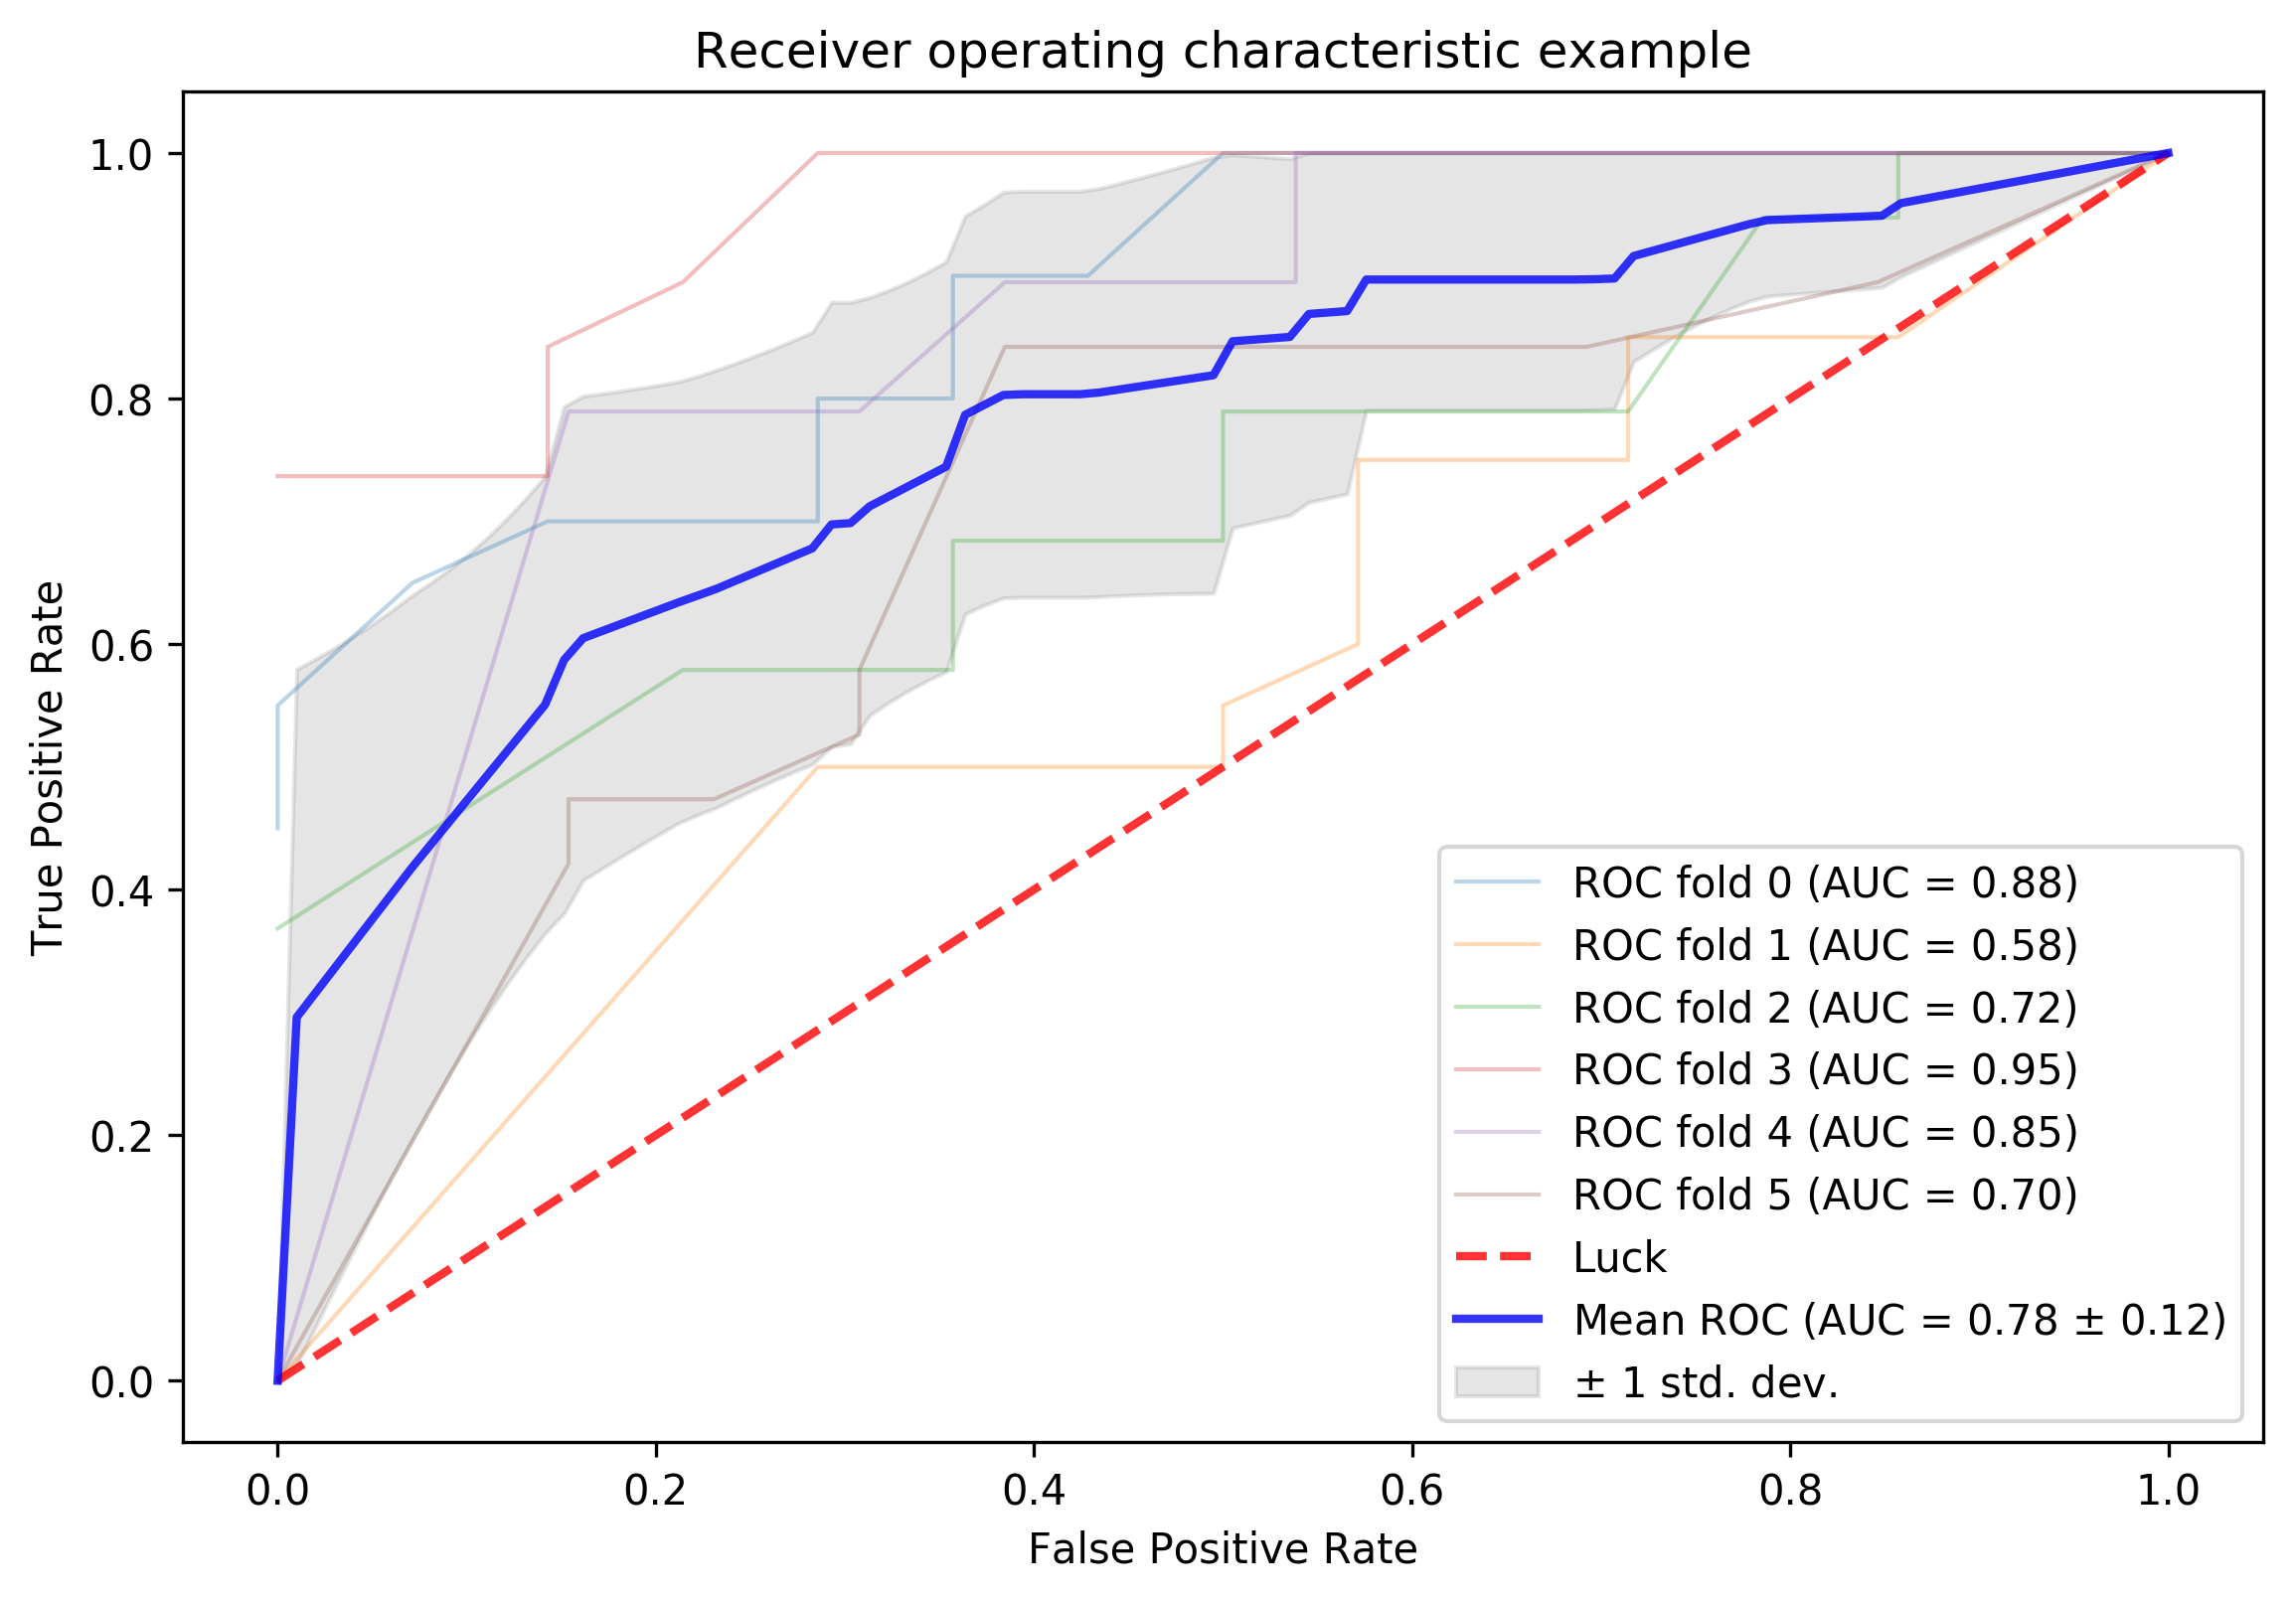

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
cv = StratifiedKFold(n_splits=6)
# classifier = svm.SVC(kernel='linear', probability=True,
#                      random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
fig=plt.figure(figsize=(9, 6), dpi= 300, facecolor='w', edgecolor='k')
for train, test in cv.split(X, Y):
    probas_ = bestModel_GBTC.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random Guess', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
# plt.show()
fig.savefig("plots/AUC_bestModel.png")

In [6]:
# modelDictAll = modelDict
modelDictPicklePath = "data/modelDict.pkl"
with open(modelDictPicklePath, "wb") as pklFile:
    pickle.dump(modelDictAll, pklFile)


In [ ]:
# modelDictPicklePath = "data/modelDict.pkl"

# with open(modelDictPicklePath, "rb") as pklFile:
#     modelDictAll = pickle.load(pklFile)

f1
[ 0.773  0.776  0.796  0.771]
[ 0.103  0.106  0.094  0.048]
recall
[ 0.759  0.793  0.871  0.948]
[ 0.141  0.151  0.132  0.086]
precision
[ 0.807  0.771  0.739  0.652]
[ 0.128  0.066  0.086  0.043]


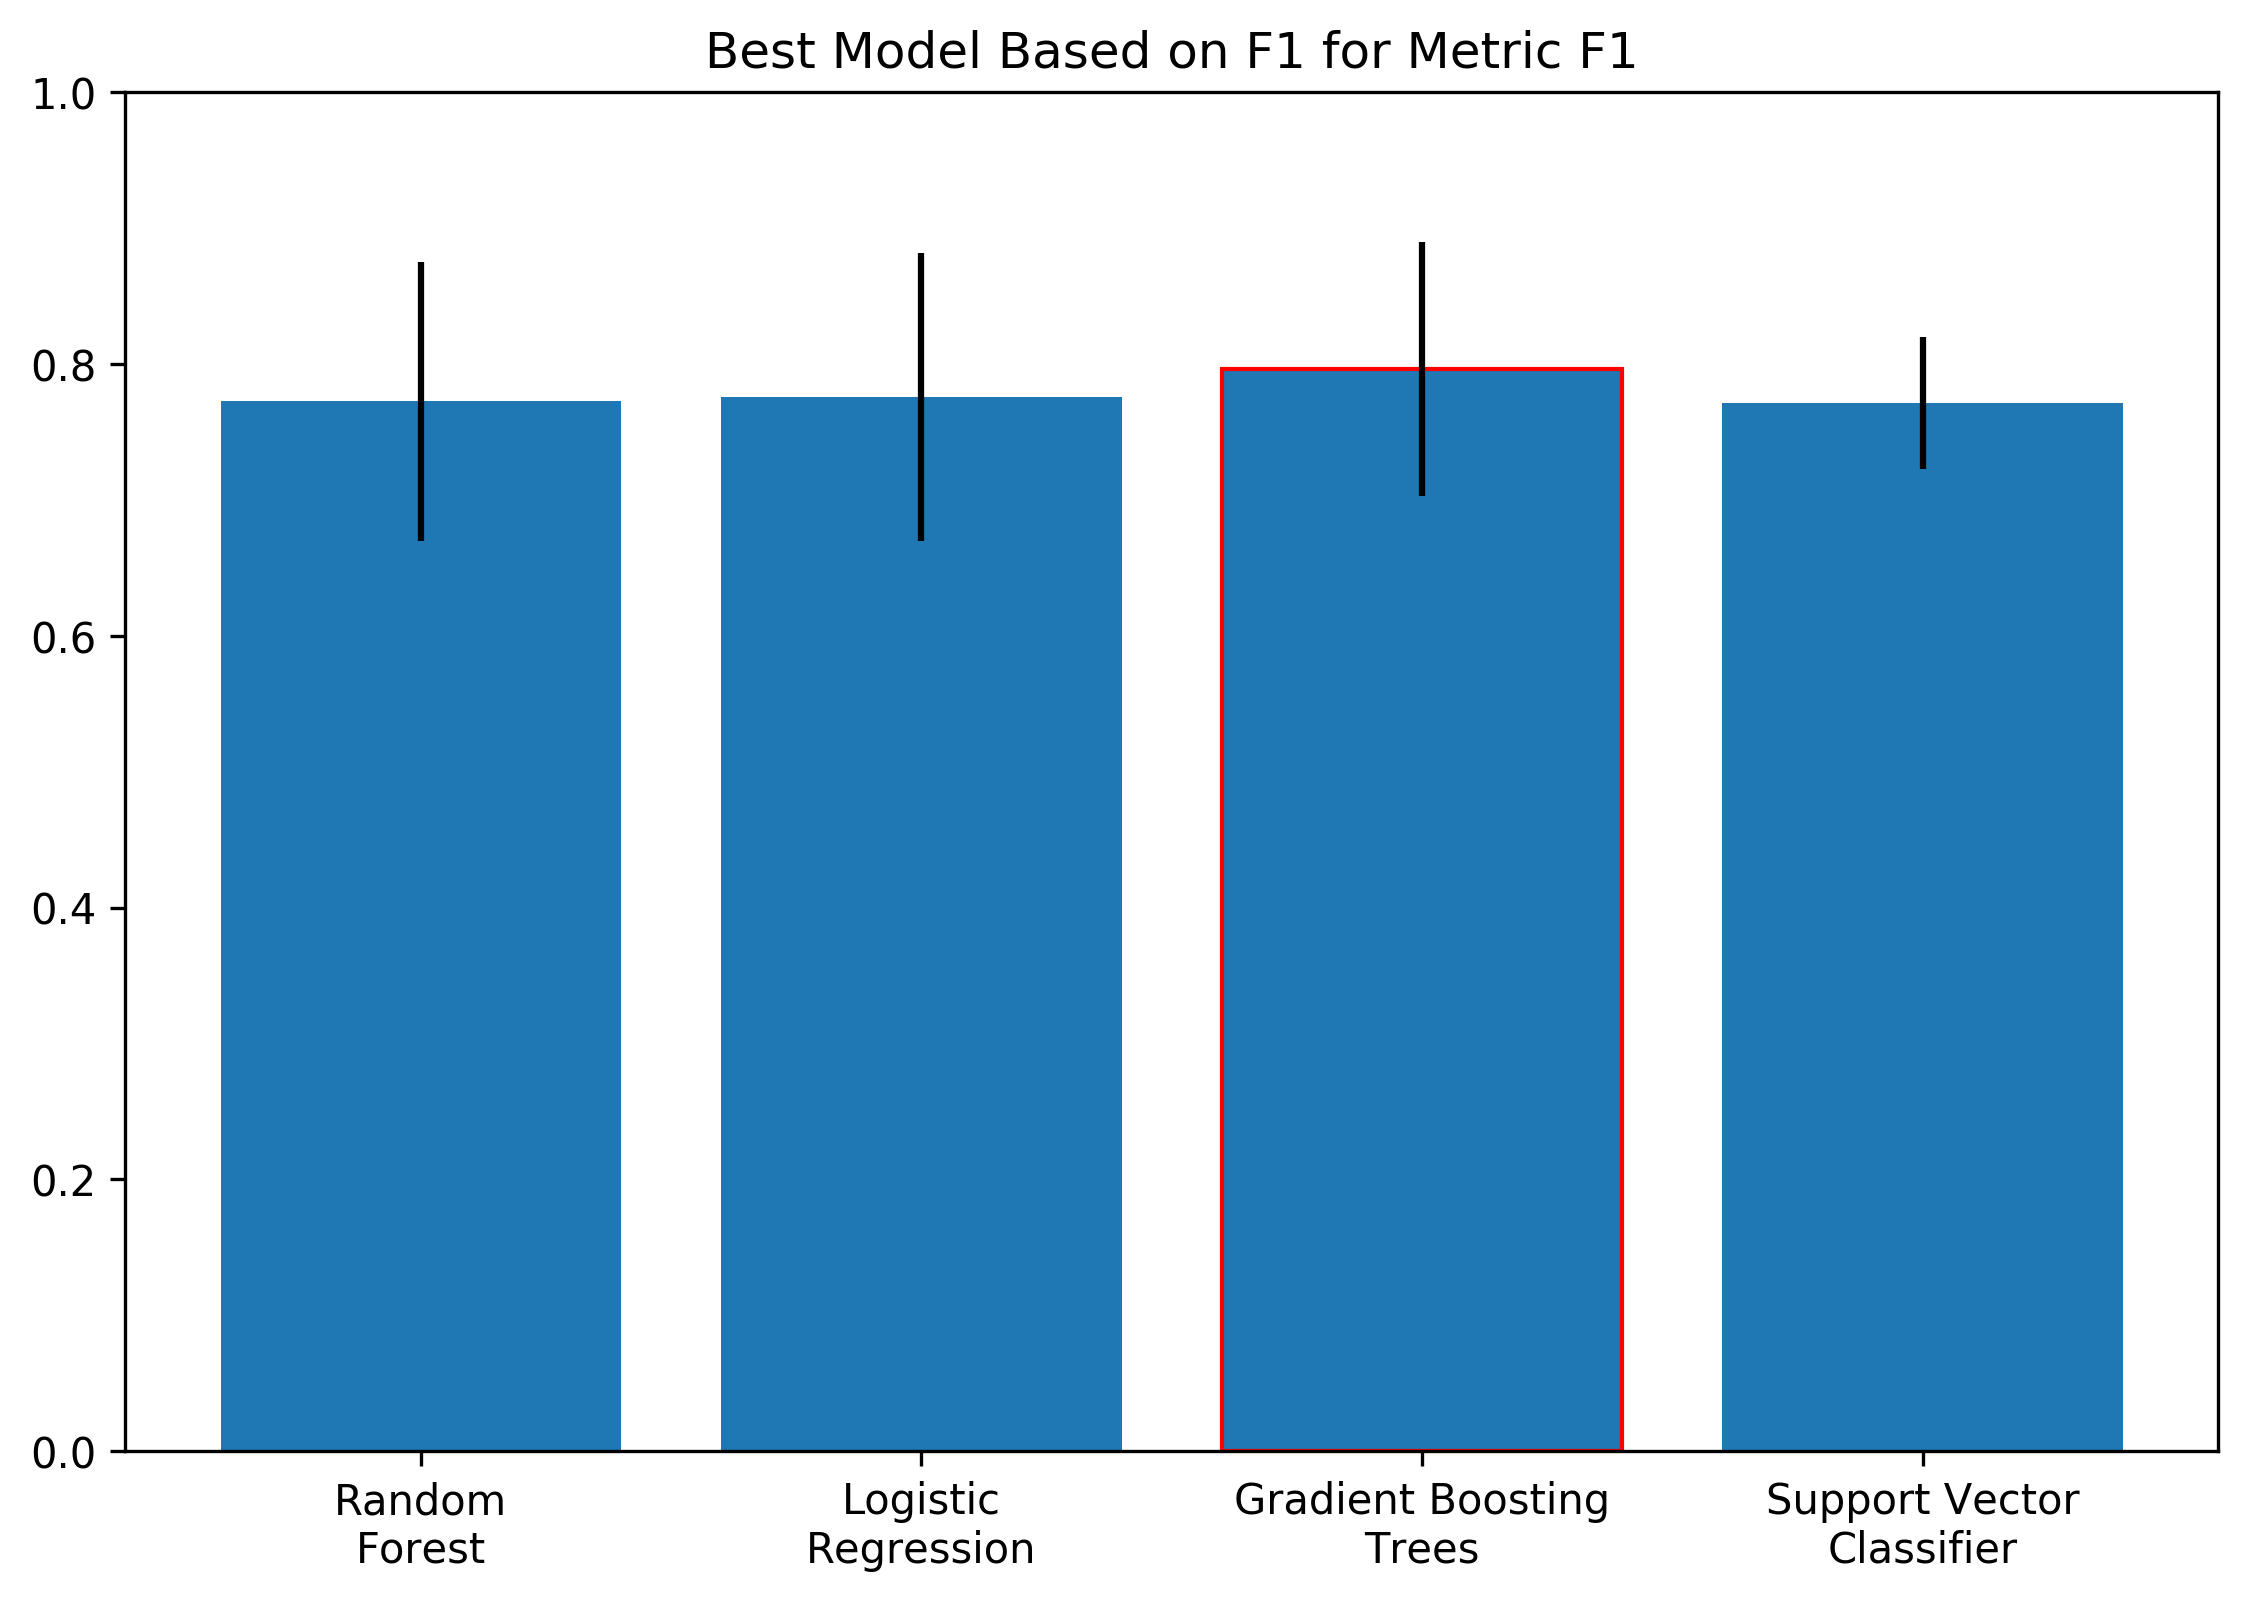

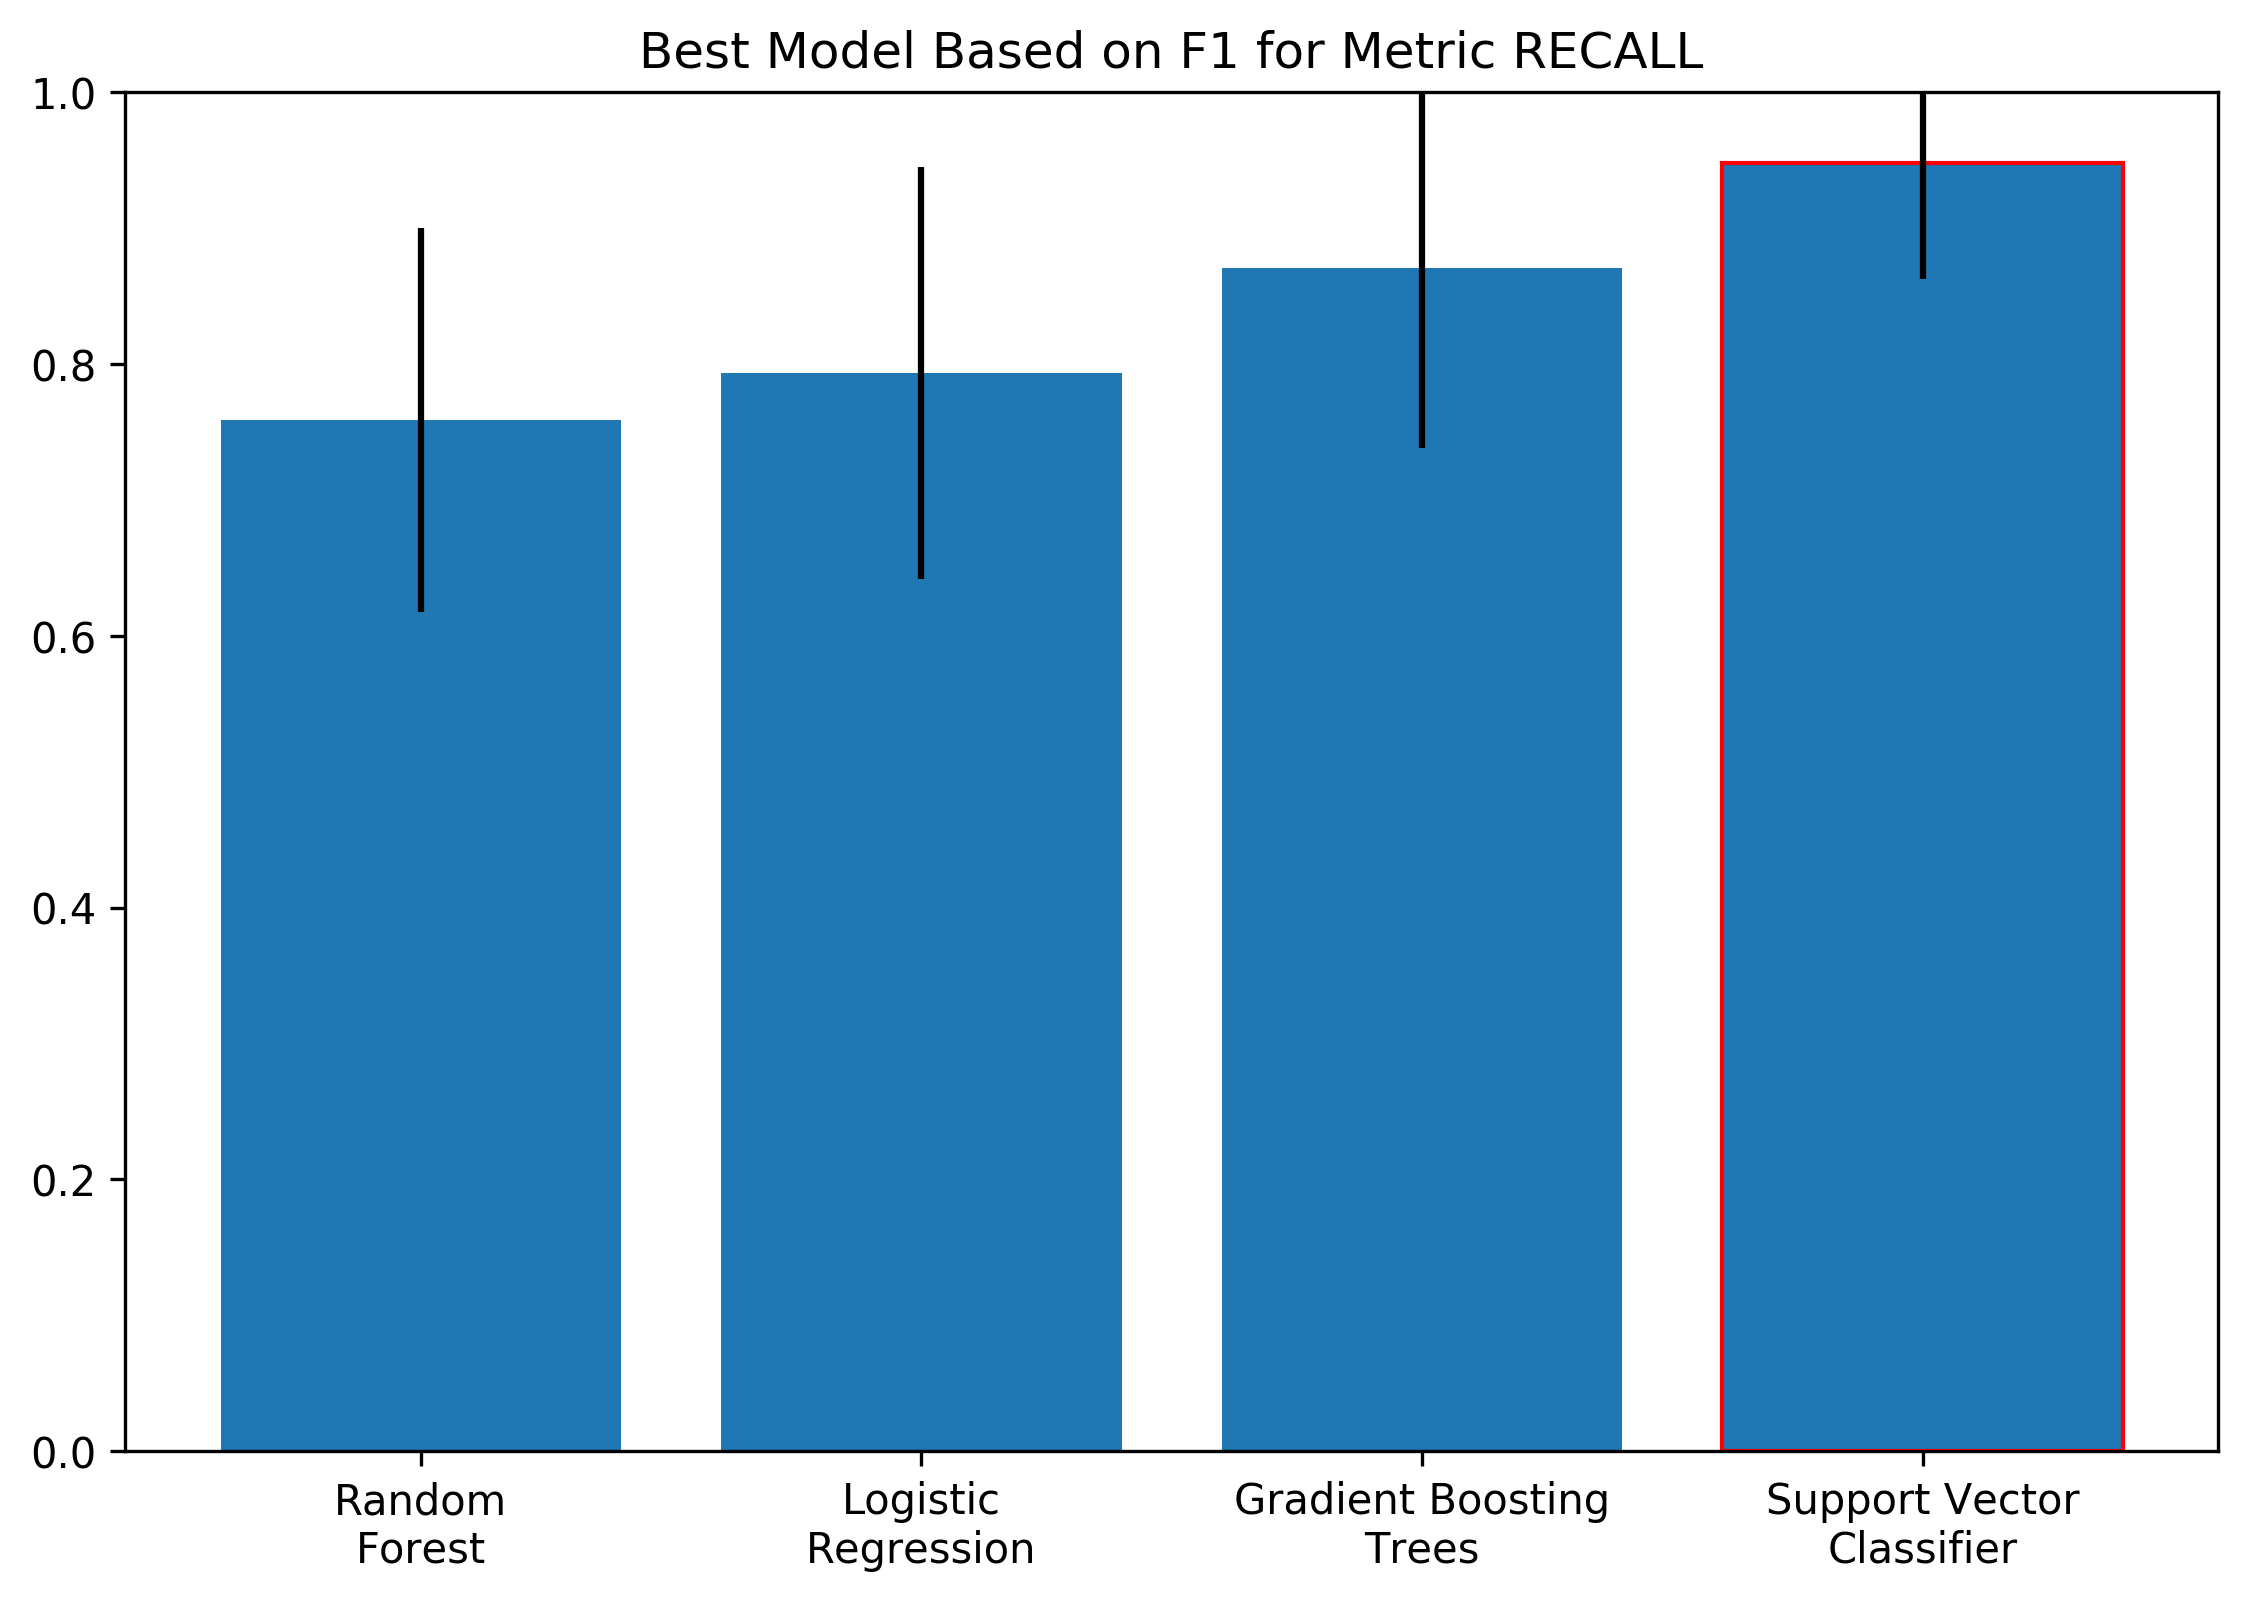

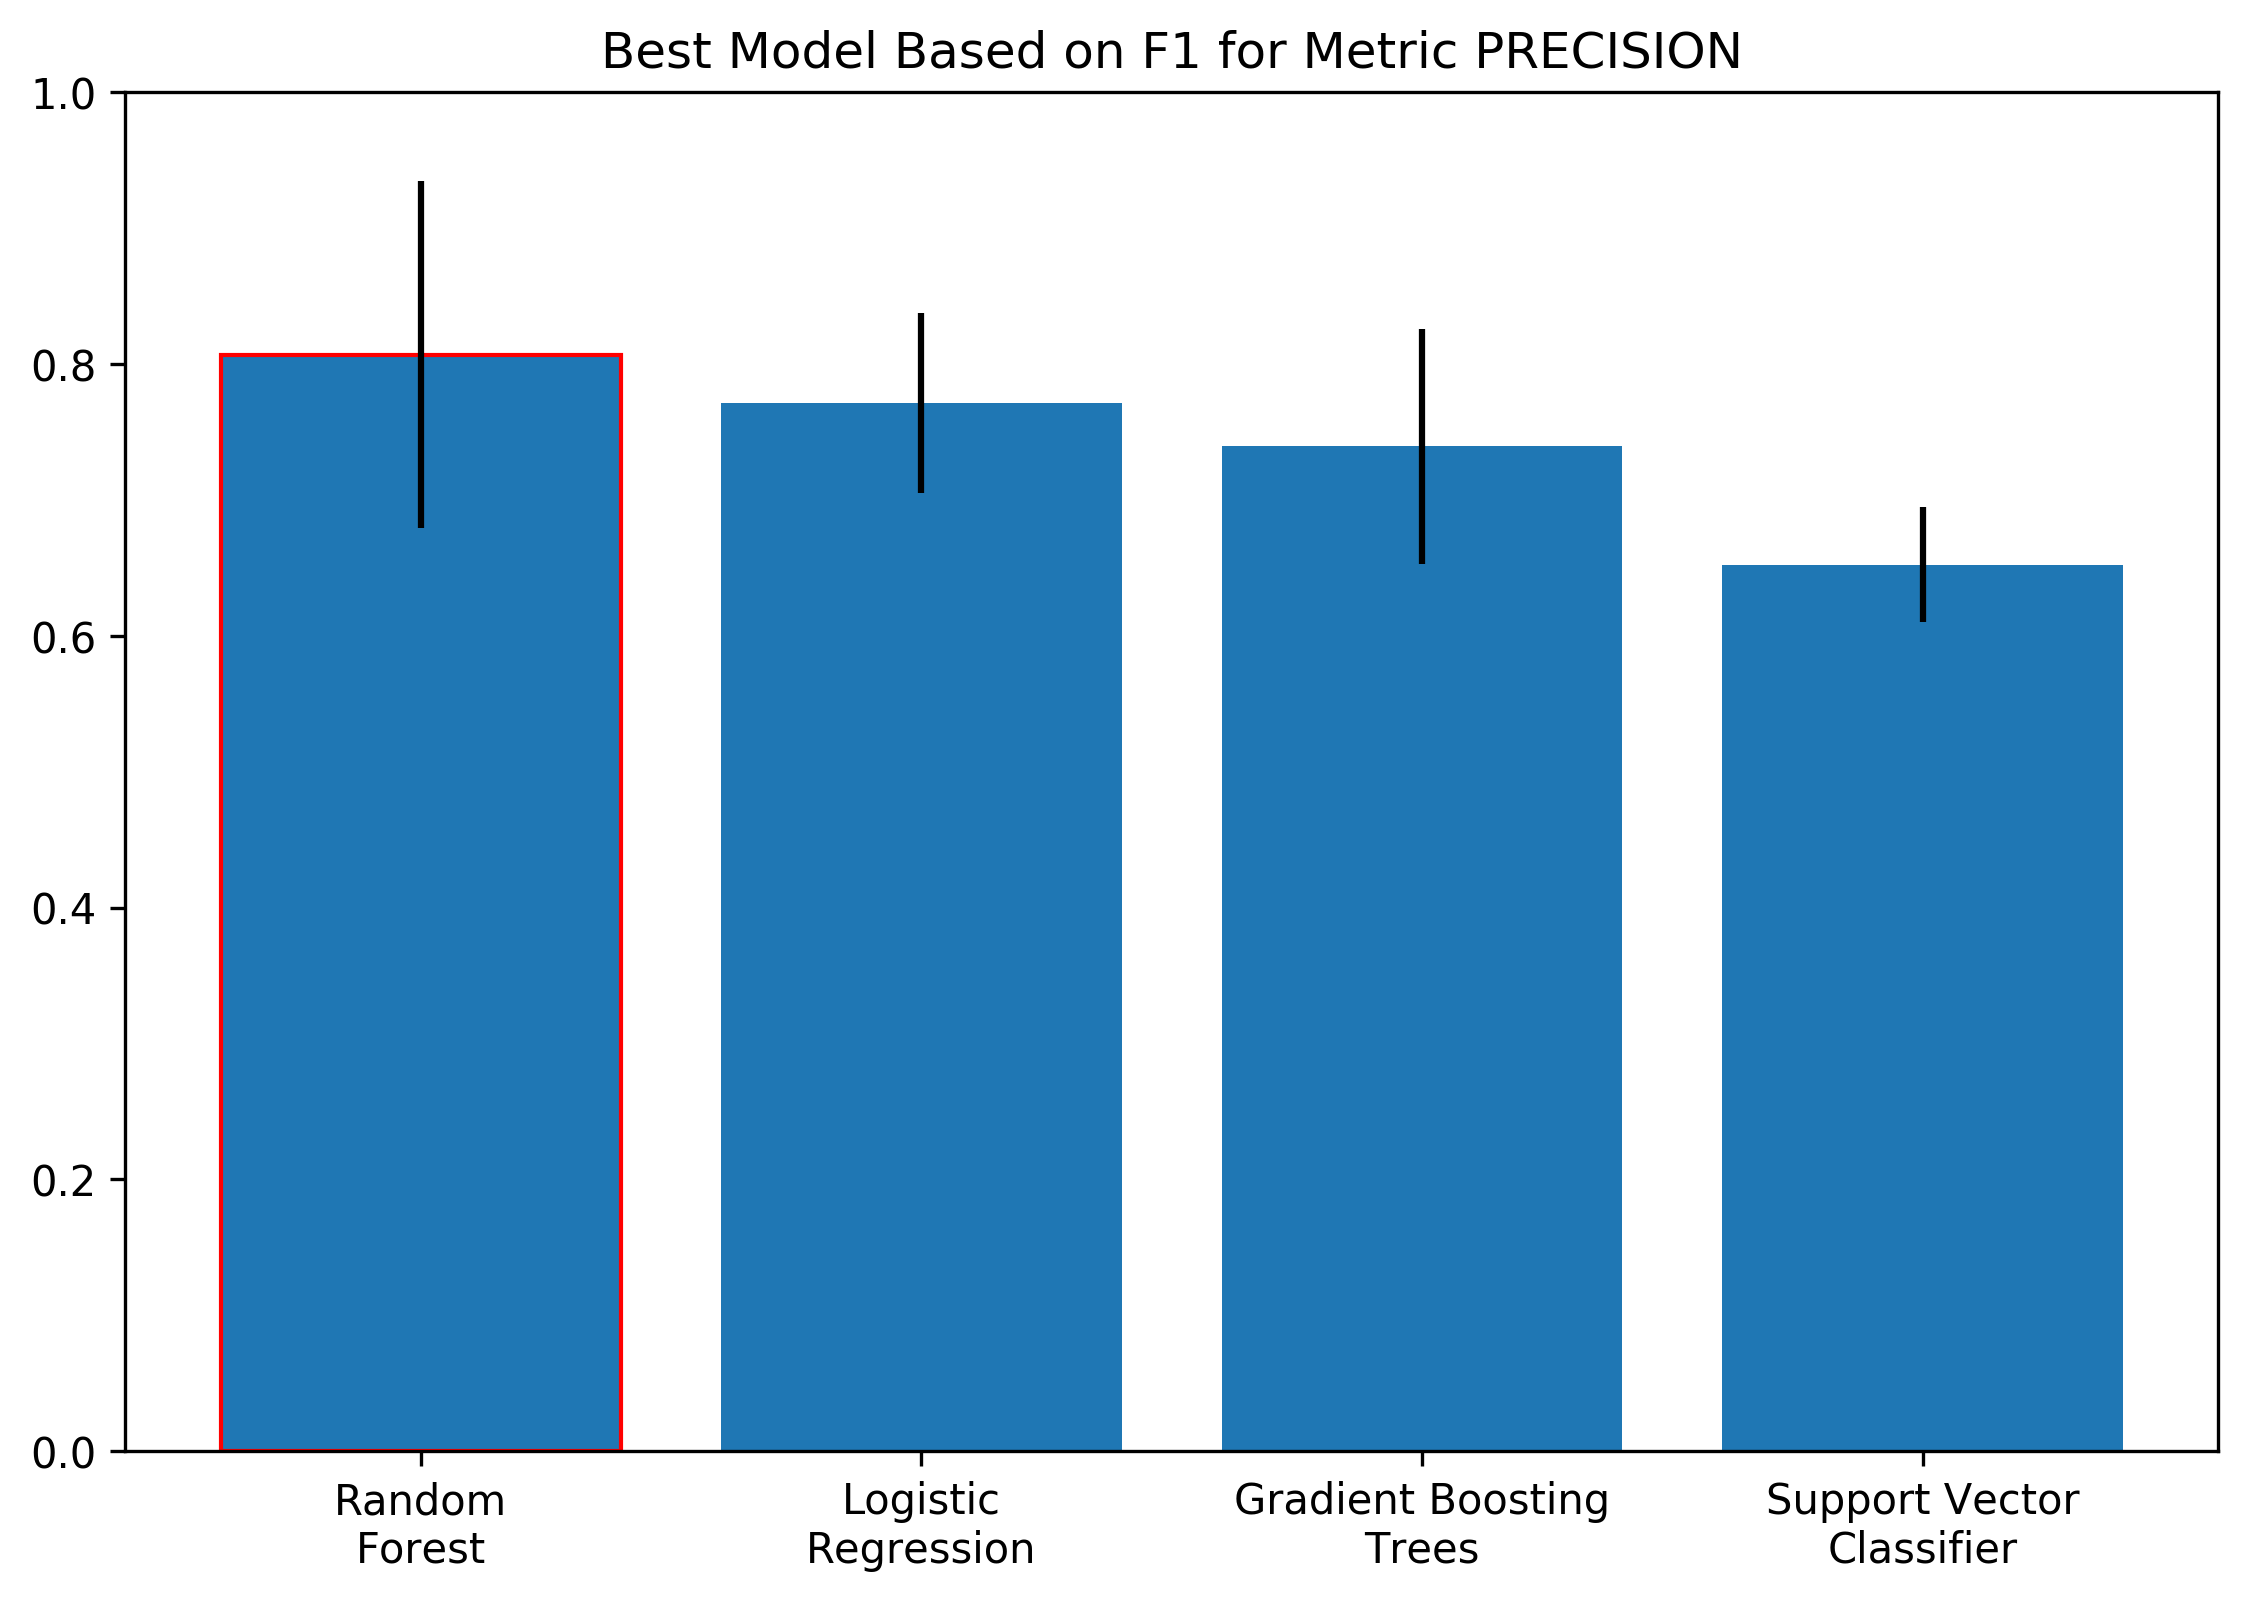

In [32]:
scoringDict = plotBestModelComparison(modelDictAll)

In [10]:
scoringDict

defaultdict(<function src.mlPipeline.plotting.plotBestModelComparison.<locals>.<lambda>>,
            {'GBTC': defaultdict(float,
                         {'f1_mean': 0.79327913770662095,
                          'f1_std': 0.092425053342588825,
                          'precision_mean': 0.7349237153715763,
                          'precision_std': 0.087682690319751788,
                          'recall_mean': 0.87071472298745012,
                          'recall_std': 0.13241676423730606}),
             'SVC': defaultdict(float,
                         {'f1_mean': 0.77132786739757431,
                          'f1_std': 0.048393165918264064,
                          'precision_mean': 0.652486683136838,
                          'precision_std': 0.042508695852810793,
                          'recall_mean': 0.9482323232323232,
                          'recall_std': 0.085533028052727}),
             'logistic': defaultdict(float,
                         {'f1_mean': 0.760770703843

# Permutation Test
After the best model has been chosen we need to see if our model is truly picking up on signal. To do this we can permute the labels, and re-estimate the CV error for the best model's parameters.

In [90]:
from time import time
start = time()

In [99]:
Y.mean()

0.5858585858585859

In [96]:
from sklearn.model_selection import cross_val_score
from time import time
nRepeats = 500
modelDict = modelDictAll["GBTC"]
bestModel = modelDict["gridcv"].best_estimator_
scoringMetric = modelDict["refitMetric"]
df = pd.read_csv(dataPath)
df = df.set_index("isolate")
X_df = df.drop(labels = ["pbr_res"], axis = 1)
X = X_df.values
Y_df = df["pbr_res"]
Y_shuffle = np.array(Y_df.values)
Y = np.array(Y_df.values)
allScoresMeanCV_shuffle = np.full(shape = nRepeats, fill_value = -1,
                                  dtype = float)
allScoresStdCV_shuffle = np.full(shape = nRepeats, fill_value = -1,
                                 dtype = float)
allScoresMeanCV_true = np.full(shape = nRepeats, fill_value = -1,
                               dtype = float)
allScoresStdCV_true = np.full(shape = nRepeats, fill_value = -1,
                              dtype = float)

# YShuffle = np.random.shuffle(Y)
shuffledIdx = np.arange(Y.shape[0])


n_cv = 10

start = time()
for i in range(nRepeats):
    np.random.shuffle(shuffledIdx)
#     print(i)
    if np.mod(i, 10) == 0:
        iterTime = time() - start
        print("Running iteration {} in {} seconds".format(i, iterTime))
        start = time()
    np.random.shuffle(Y_shuffle)
    currScoresCV_shuffle = cross_val_score(estimator = bestModel, X = X, y = Y_shuffle,
                                           cv = n_cv, n_jobs = 3, verbose = 0, 
                                           scoring = scoringMetric)
    X = X[shuffledIdx, :]
    Y = Y[shuffledIdx]
    currScoresCV_true = cross_val_score(estimator = bestModel, X = X, y = Y,
                                           cv = n_cv, n_jobs = 3, verbose = 0, 
                                           scoring = scoringMetric)
    allScoresMeanCV_shuffle[i] = currScoresCV_shuffle.mean()
    allScoresStdCV_shuffle[i] = np.std(currScoresCV_shuffle)
    allScoresMeanCV_true[i] = currScoresCV_true.mean()
    allScoresStdCV_true[i] = np.std(currScoresCV_true)
#     print(allScoresMeanCV_shuffle)
#     print(allScoresMeanCV_true)
    

# take in best model
# take in data
# take in n for permutations
# take in optional test set
# take in cv if not test set.
from scipy.stats import ttest_ind
ttest_ind(a = allScoresMeanCV_shuffle,
          b = allScoresMeanCV_true)

Running iteration 0 in 0.0004374980926513672 seconds
Running iteration 10 in 142.70513892173767 seconds
Running iteration 20 in 140.95882320404053 seconds
Running iteration 30 in 142.8495650291443 seconds
Running iteration 40 in 143.63306164741516 seconds
Running iteration 50 in 149.58917498588562 seconds
Running iteration 60 in 143.65398240089417 seconds
Running iteration 70 in 145.91169714927673 seconds
Running iteration 80 in 142.4729940891266 seconds
Running iteration 90 in 139.5033118724823 seconds
Running iteration 100 in 142.23135137557983 seconds
Running iteration 110 in 141.36219310760498 seconds
Running iteration 120 in 142.11380338668823 seconds
Running iteration 130 in 141.0321683883667 seconds
Running iteration 140 in 141.4959008693695 seconds
Running iteration 150 in 145.7419421672821 seconds
Running iteration 160 in 143.68236231803894 seconds
Running iteration 170 in 141.1173813343048 seconds
Running iteration 180 in 141.3674533367157 seconds
Running iteration 190 in 137

Ttest_indResult(statistic=-81.82435501231497, pvalue=0.0)

In [97]:
# print(allScoresMeanCV_true)
print(allScoresMeanCV_true.mean())

0.7917147344502476


In [98]:
# print(allScoresMeanCV_shuffle)
print(allScoresMeanCV_shuffle.mean())

0.6713257240119844


In [81]:
from scipy.stats import ttest_ind
ttest_ind(a = allScoresMeanCV_shuffle,
          b = allScoresMeanCV_true)

Ttest_indResult(statistic=-10.2938403477768, pvalue=5.708760935926584e-09)

In [35]:
temp.mean()

0.6860170167441533

In [39]:
np.mod(10, 4)

2

In [12]:
bestModel.best_estimator_

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('linSVC_dimReduction', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_st...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [13]:
modelDictAll["GBTC"].keys()

dict_keys(['gridcv', 'refitMetric', 'pipe', 'params'])

In [14]:
modelDictAll["GBTC"]["pipe"]

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('linSVC_dimReduction', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_st...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [9]:
temp.issubset(temp)

True

In [26]:
currModelBestIdx = modelDict["GBTC"]["gridcv"].best_index_

modelDict["GBTC"]["gridcv"].cv_results_.keys()

dict_keys(['split6_test_recall', 'rank_test_accuracy', 'split1_test_precision', 'split0_test_accuracy', 'rank_test_precision', 'split4_test_accuracy', 'split3_test_accuracy', 'split5_test_f1', 'params', 'split7_test_precision', 'mean_test_precision', 'mean_test_recall', 'split6_test_f1', 'mean_fit_time', 'split3_test_f1', 'split4_test_f1', 'std_score_time', 'param_GBTC__max_depth', 'split5_test_precision', 'rank_test_f1', 'split6_test_accuracy', 'param_GBTC__n_estimators', 'split3_test_recall', 'split1_test_recall', 'split5_test_accuracy', 'mean_test_f1', 'split2_test_f1', 'param_GBTC__learning_rate', 'mean_score_time', 'rank_test_recall', 'split5_test_recall', 'split0_test_precision', 'split9_test_precision', 'split6_test_precision', 'mean_test_accuracy', 'std_test_precision', 'split2_test_recall', 'std_test_accuracy', 'split8_test_accuracy', 'split4_test_recall', 'split7_test_recall', 'split7_test_accuracy', 'split1_test_f1', 'split4_test_precision', 'std_test_f1', 'split7_test_f1', 

In [63]:
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import LassoCV
import numpy as np

## Read in the Data

In [3]:
dataPath = "../../data/MLData/inst_feature_matrix_non_syn_20180329.csv"

In [4]:
df = pd.read_csv(dataPath)
df = df.set_index("isolate")
X_df = df.drop(labels = ["pbr_res"], axis = 1)
X = X_df.values
Y_df = df["pbr_res"]
Y = Y_df.values

## Feature Selection

In [69]:
# feature selection union
# unused right now
features = []
# features.append(('pca', PCA(n_components=3)))
# features.append(('select_best', SelectKBest(k=6)))
# clf = LassoCV()

# Set a minimum threshold of 0.25
features.append(("linSVC_dimReduction", SelectFromModel(LinearSVC(), 0.25)))
# features.append(("lasso_dimReduction", SelectFromModel(LassoCV(), 0.25)))
# features.append(SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False),
#                                 threshold=0.25, prefit = False))
feature_union = FeatureUnion(features)
featureSelectionParamGrid = {} # TODO implement feature selection for feature selection.

## Models

In [70]:
modelDict = {}
cv = 10
n_jobs = 3
# TODO when you perform CV with this stuff consider doing memory option stuff
scoring = ["accuracy", "f1", "precision", "recall"]
importantMetric = "f1"



# create pipeline for logisttic Regression
estimators_LR = []
estimators_LR.append(('feature_union', feature_union))
estimators_LR.append(('logistic', LogisticRegression()))
# estimators.append(models)
paramGrid_LR = [
    {
        "logistic__penalty": ['l1', 'l2'],
        "logistic__C": [1, 10, 100, 1000]
    }
]
modelDict["logistic"] = {"pipe": Pipeline(estimators_LR),
                         "params": paramGrid_LR}
modelDict["logistic"]["gridcv"] = GridSearchCV(estimator = modelDict["logistic"]["pipe"],
                         param_grid = modelDict["logistic"]["params"],
                         cv = cv, n_jobs = n_jobs, return_train_score = False,
                         scoring = scoring, refit = importantMetric)
# TODO understand how linearSVC works with these parameters




# create pipeline for RF
estimators_RF = []
estimators_RF.append(('feature_union', feature_union))
estimators_RF.append(('RFC', RandomForestClassifier()))
# estimators.append(models)
paramGrid_RF = [
    {
        "RFC__n_estimators": [5, 10, 15, 20],# second most important feature to tune. First
        # is max number of feats.
        "RFC__max_features": ["sqrt", "log2", 0.5],# we have lots of possibly dumb
        # features so it might be good to use lower numbers here
        "RFC__max_depth": [None],# still need to understand if deeper trees are better.
        "RFC__criterion":["gini"],# no idea if this will make a difference. can check
    }
]

modelDict["randomForest"] = {"pipe": Pipeline(estimators_RF),
                             "params": paramGrid_RF}
modelDict["randomForest"]["gridcv"] = GridSearchCV(estimator = modelDict["randomForest"]["pipe"],
                       param_grid = modelDict["randomForest"]["params"],
                       cv = cv, n_jobs = n_jobs, return_train_score = False,
                       scoring = scoring, refit = importantMetric)
#TODO is it better to build RF trees to purity and prune?





# Create pipeline for SVC
estimators_SVC = []
estimators_SVC.append(('feature_union', feature_union))
estimators_SVC.append(('SVC', SVC()))
# estimators.append(models)
paramGrid_SVC = [
    {
        "SVC__kernel": ['rbf', 'poly', "sigmoid"],
        "SVC__C": [1, 10, 100, 1000]
    }
]
modelDict["SVC"] = {"pipe":Pipeline(estimators_SVC),
                    "params": paramGrid_SVC}
modelDict["SVC"]["gridcv"] = GridSearchCV(estimator = modelDict["SVC"]["pipe"],
                       param_grid = modelDict["SVC"]["params"],
                       cv = cv, n_jobs = n_jobs, return_train_score = False,
                       scoring = scoring, refit = importantMetric)



# create pipeline for GBTC
estimators_GBTC = []
estimators_GBTC.append(('feature_union', feature_union))
estimators_GBTC.append(('GBTC', GradientBoostingClassifier()))
# estimators.append(models)
paramGrid_GBTC = [
    {
        "GBTC__learning_rate": [0.001, 0.01, 0.1],
        "GBTC__n_estimators": [50, 100, 200, 300, 400, 500],
        "GBTC__max_depth": [1, 3, 5, 10, 12]
    }
]
modelDict["GBTC"] = {"pipe": Pipeline(estimators_GBTC),
                     "params": paramGrid_GBTC}
modelDict["GBTC"]["gridcv"] = GridSearchCV(estimator = modelDict["GBTC"]["pipe"],
                       param_grid = modelDict["GBTC"]["params"],
                       cv = cv, n_jobs = n_jobs, return_train_score = False,
                       scoring = scoring, refit = importantMetric)
# modelDict["gradientBosting"] = Pipeline(estimators_GBTC)

In [71]:
modelDict.keys()

dict_keys(['logistic', 'randomForest', 'SVC', 'GBTC'])

In [72]:
def printBestModelStatistics(gridScoresCV, scoring, modelName):
    scoringDict = {}
    bestModelIndex = currModelDict["gridcv"].best_index_
    for score in scoring:
        scoringDict[score] = gridScoresCV["mean_test_" + score][bestModelIndex]
        outStr = "For Model {}:".format(modelName)
    for scoreName, scoreVal in scoringDict.items():
        outStr += "\n\t{}: {}".format(scoreName, np.round(scoreVal, decimals = 3))
    print(outStr)  

In [76]:
for modelName, currModelDict in modelDict.items():
    print("Training {}".format(modelName))
    currModelDict["gridcv"].fit(X,Y)
    printBestModelStatistics(gridScoresCV = currModelDict["gridcv"].cv_results_,
                         scoring = scoring, modelName = modelName)
    print("Best Model Parameters {}".format(currModelDict["gridcv"].best_params_))
    print("*"*100)
#     break

Training logistic
For Model logistic:
	accuracy:0.625
	f1:0.642
	precision:0.656
	recall:0.646
Best Model Parameters {'logistic__C': 100, 'logistic__penalty': 'l1'}
****************************************************************************************************
Training randomForest
For Model randomForest:
	accuracy:0.615
	f1:0.633
	precision:0.63
	recall:0.654
Best Model Parameters {'RFC__criterion': 'gini', 'RFC__max_depth': None, 'RFC__max_features': 0.5, 'RFC__n_estimators': 5}
****************************************************************************************************
Training SVC
For Model SVC:
	accuracy:0.535
	f1:0.697
	precision:0.535
	recall:1.0
Best Model Parameters {'SVC__C': 1, 'SVC__kernel': 'poly'}
****************************************************************************************************
Training GBTC


/home/ob2285/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ob2285/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For Model GBTC:
	accuracy:0.535
	f1:0.697
	precision:0.535
	recall:1.0
Best Model Parameters {'GBTC__learning_rate': 0.001, 'GBTC__max_depth': 1, 'GBTC__n_estimators': 50}
****************************************************************************************************


In [74]:
currModelDict["gridcv"].best_params_

{'GBTC__learning_rate': 0.001, 'GBTC__max_depth': 1, 'GBTC__n_estimators': 50}

In [75]:
currModelDict["gridcv"].best_estimator_

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('linSVC_dimReduction', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_st...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [20]:
currModelDict["gridcv"].cv_results_["mean_test_f1"]

array([ 0.60934862,  0.60539875,  0.63101533,  0.60208662,  0.64175126,
        0.63199824,  0.64175126,  0.6360675 ])

In [27]:
gridScoresCV = currModelDict["gridcv"].cv_results_
modelName = "Logistic"
scoringDict = {}
bestModelIndex = currModelDict["gridcv"].best_index_
for score in scoring:
    scoringDict[score] = gridScoresCV["mean_test_" + score][bestModelIndex]
outStr = "For Model {}:".format(modelName)
for scoreName, scoreVal in scoringDict.items():
    outStr += "\n\t{}:{}".format(scoreName, np.round(scoreVal, decimals = 3))
print(outStr)
def printBestModelStatistics(gridScoresCV, scoring, modelName):
    scoringDict = {}
    bestModelIndex = currModelDict["gridcv"].best_index_
    for score in scoring:
        scoringDict[score] = gridScoresCV["mean_test_" + score][bestModelIndex]
        outStr = "For Model {}:".format(modelName)
    for scoreName, scoreVal in scoringDict.items():
        outStr += "\n\t{}:{}".format(scoreName, np.round(scoreVal, decimals = 3))
    print(outStr)  

For Model Logistic:
	accuracy:0.625
	f1:0.642
	precision:0.656
	recall:0.646


In [28]:
printBestModelStatistics(gridScoresCV = currModelDict["gridcv"].cv_results_,
                         scoring = scoring, modelName = modelName)

For Model Logistic:
	accuracy:0.625
	f1:0.642
	precision:0.656
	recall:0.646


In [66]:
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
scoring = ["accuracy", "f1", "precision", "recall"]
metrics = {}
for modelName, model in modelDict.items():
#     print(model)
    results = cross_validate(model, X, Y, cv=kfold,  scoring=scoring, )
#     results = cross_val_score(estimator=model,
#                               X=features,
#                               y=labels,
#                               cv=kfold,
#                               scoring=scoring)
#     break
    for idx, metric in enumerate(scoring):
        metrics[metric] = results["test_"+metric].mean()
#     accMean = results["test_"+scoring[idx]].mean()
    print("Metrics for {}".format(modelName))
    print(metrics)
    print("\n")
#     break
# kfold = KFold(n_splits=10, random_state=seed)
# results = cross_val_score(model, X, Y, cv=kfold)
# print(results.mean())

Metrics for logistic
{'accuracy': 0.55999999999999994, 'f1': 0.50657429607429605, 'precision': 0.61407661782661782, 'recall': 0.51237412913883507}


Metrics for randomForest
{'accuracy': 0.53499999999999992, 'f1': 0.47718709972744716, 'precision': 0.5924009324009325, 'recall': 0.46138116785175615}


Metrics for SVC
{'accuracy': 0.35999999999999999, 'f1': 0.504621863504922, 'precision': 0.49444444444444435, 'recall': 0.80264705882352949}


Metrics for gradientBosting
{'accuracy': 0.55999999999999994, 'f1': 0.49615496098104794, 'precision': 0.54168831168831166, 'recall': 0.49498383968972204}




In [65]:
results

{'fit_time': array([ 0.08118463,  0.07761335,  0.08058453,  0.07894659,  0.07932329,
         0.07868505,  0.08367991,  0.08803058,  0.08775806,  0.08080649]),
 'score_time': array([ 0.00208187,  0.00207233,  0.00208974,  0.00207472,  0.00207257,
         0.00202703,  0.00224113,  0.00220537,  0.00201702,  0.00197744]),
 'test_accuracy': array([ 0.8 ,  0.35,  0.6 ,  0.35,  0.65,  0.55,  0.6 ,  0.45,  0.5 ,  0.75]),
 'test_f1': array([ 0.85714286,  0.48      ,  0.75      ,  0.51851852,  0.69565217,
         0.52631579,  0.33333333,  0.26666667,  0.        ,  0.61538462]),
 'test_precision': array([ 0.75      ,  0.4       ,  0.8       ,  1.        ,  0.8       ,
         0.5       ,  0.4       ,  0.25      ,  0.        ,  0.57142857]),
 'test_recall': array([ 1.        ,  0.6       ,  0.70588235,  0.35      ,  0.61538462,
         0.55555556,  0.28571429,  0.28571429,  0.        ,  0.66666667]),
 'train_accuracy': array([ 0.88888889,  0.86666667,  0.88333333,  0.88333333,  0.87777778,
  

In [42]:
results

array([0.75, 0.35, 0.7 , 0.6 , 0.4 , 0.55, 0.65, 0.5 , 0.7 , 0.85])

In [39]:
model = Pipeline(estimators_GBTC)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.5900000000000001


In [36]:
model

Pipeline(memory=None,
     steps=[('GBTC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [8]:
np.mean(Y)

0.535

In [33]:
modelDict

{'SVC': Pipeline(memory=None,
      steps=[('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False))]), 'gradientBosting': Pipeline(memory=None,
      steps=[('GBTC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False))]), 'logistic': Pipeline(memory=None,
      steps=[('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max